In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

X.shape, y.shape

((442, 10), (442,))

In [2]:
# preparing dataset for pytorch
torch.manual_seed(42)

X_values = X.values
y_values = y.values.reshape(-1, 1)
# scaling the inputs tensors
scaler = StandardScaler()
inputs_scaled = scaler.fit_transform(X_values)

inputs_tensor = torch.tensor(inputs_scaled, dtype=torch.float32)
target_tensor = torch.tensor(y_values, dtype=torch.float32)

n_samples = X.shape[0]
indices = torch.randperm(n_samples)
split_idx = int(n_samples * 0.8)

train_indices = indices[:split_idx]
test_indices  = indices[split_idx:]

X_train, X_test, y_train, y_test = inputs_tensor[train_indices], inputs_tensor[test_indices], target_tensor[train_indices], target_tensor[test_indices]


# initialize weights and bias
n_features = X_train.shape[1]
W = torch.randn((n_features, 1), requires_grad = True)
b = torch.zeros((1,), requires_grad = True)

In [3]:
def predict(X):
    return torch.matmul(X, W) + b

def mse_loss(predictions, targets):
    return torch.mean((predictions - targets) ** 2)

In [4]:
learning_rate = 0.001
epochs = 500
losses = []
for epoch in range(1, epochs+1):
    # make predictions
    y_pred = predict(X_train)

    # compute loss
    loss = mse_loss(y_pred, y_train)
    losses.append(loss.item())

    # backward propagation
    loss.backward()

    # update parameters W and b
    with torch.no_grad():
        W -= learning_rate * W.grad
        b -= learning_rate * b.grad
    
    W.grad.zero_()
    b.grad.zero_()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}: Loss = {loss.item()}')

Epoch: 10: Loss = 27967.84375
Epoch: 20: Loss = 26753.005859375
Epoch: 30: Loss = 25620.30859375
Epoch: 40: Loss = 24561.263671875
Epoch: 50: Loss = 23568.529296875
Epoch: 60: Loss = 22635.7265625
Epoch: 70: Loss = 21757.314453125
Epoch: 80: Loss = 20928.447265625
Epoch: 90: Loss = 20144.8984375
Epoch: 100: Loss = 19402.943359375
Epoch: 110: Loss = 18699.30859375
Epoch: 120: Loss = 18031.095703125
Epoch: 130: Loss = 17395.736328125
Epoch: 140: Loss = 16790.94140625
Epoch: 150: Loss = 16214.6630859375
Epoch: 160: Loss = 15665.06640625
Epoch: 170: Loss = 15140.490234375
Epoch: 180: Loss = 14639.4375
Epoch: 190: Loss = 14160.5498046875
Epoch: 200: Loss = 13702.5810546875
Epoch: 210: Loss = 13264.396484375
Epoch: 220: Loss = 12844.94921875
Epoch: 230: Loss = 12443.2802734375
Epoch: 240: Loss = 12058.494140625
Epoch: 250: Loss = 11689.7666015625
Epoch: 260: Loss = 11336.32421875
Epoch: 270: Loss = 10997.451171875
Epoch: 280: Loss = 10672.46875
Epoch: 290: Loss = 10360.75390625
Epoch: 300: L

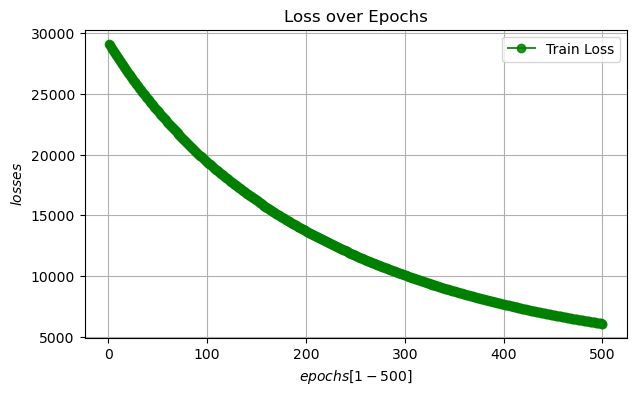

In [5]:
plt.figure(figsize=(7,4))
plt.plot(range(1, 501), losses, color='green', marker='o', alpha=0.85, label='Train Loss')
plt.xlabel('$epochs [1 - 500]$')
plt.ylabel('$losses$')
plt.title('Loss over Epochs')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

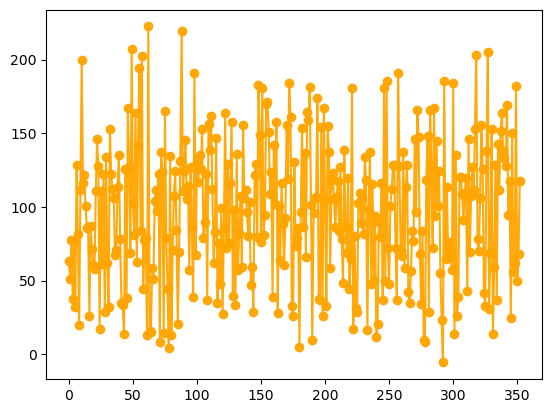

In [6]:
# make test prediction and plot both train and test predicts

y_test_pred = predict(X_test)
test_loss = mse_loss(y_test_pred, y_test)

#plt.plot(y_test_pred.detach().numpy(), color='green', alpha=0.95, marker='^')
plt.plot(y_pred.detach().numpy(), color='orange', alpha=0.95, marker='o');

### Building a non-linear custom model

In [7]:
from tqdm import tqdm

In [8]:
input_size = X_train.shape[1]
hidden_size = 20
output_size = 1

lr = 0.001
losses = []
epochs = 3000

W1_relu = torch.randn(input_size, hidden_size, requires_grad = True)
b1_relu = torch.randn(hidden_size, requires_grad = True)
W2_relu = torch.randn(hidden_size, output_size, requires_grad = True)
b2_relu = torch.randn((output_size,), requires_grad = True)


def my_relu(x):
    return torch.clamp(x, min=0)

def predict_relu(X):
    hidden_layer = my_relu(torch.matmul(X, W1_relu) + b1_relu)
    output_layer = hidden_layer @ W2_relu + b2_relu
    return output_layer

def mse_loss(predictions, targets):
    return ((predictions - targets) ** 2).mean()

In [9]:
for epoch in tqdm(range(epochs)):
    # make prediction
    y_pred_train = predict_relu(X_train)
    # compute loss
    loss = mse_loss(y_pred_train, y_train)
    # append losses
    losses.append(loss.item())
    loss.backward()

    with torch.no_grad():
        W1_relu -= lr * W1_relu.grad
        W2_relu -= lr * W2_relu.grad
        b1_relu -= lr * b1_relu.grad
        b2_relu -= lr * b2_relu.grad

        W1_relu.grad.zero_()
        W2_relu.grad.zero_()
        b1_relu.grad.zero_()
        b2_relu.grad.zero_()

100%|██████████| 3000/3000 [00:02<00:00, 1095.58it/s]


### Custom MLP class

In [10]:
from torch import nn
import torch.optim as optim

In [11]:
X_train.shape

torch.Size([353, 10])

In [12]:
class CustomMLPModel(nn.Module):
    def __init__(self):
        super(CustomMLPModel, self).__init__()
        self.fc1 = nn.Linear(in_features=X_train.shape[1], out_features=20)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(20, 12)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(12, 1) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

model = CustomMLPModel()
print(model)
  

CustomMLPModel(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=20, out_features=12, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=12, out_features=1, bias=True)
)


### Define Loss and optimzer


In [13]:
loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [14]:
# train the model

train_losses = []
epochs = 5000

for epoch in tqdm(range(1, epochs + 1)):
    y_train_pred = model(X_train)
    loss = loss_fn(y_train_pred, y_train)
    train_losses.append(loss.item())

    loss.backward()

    # learn parameters
    optimizer.step()

    # zeroing parameters
    optimizer.zero_grad()

    if (epoch % 100) == 0:
        print(f'At Epoch: {epoch}, Loss is: {loss.item()}')

  1%|          | 40/5000 [00:00<00:30, 160.41it/s]

  3%|▎         | 136/5000 [00:00<00:28, 173.25it/s]

At Epoch: 100, Loss is: 3669.11328125


  4%|▍         | 195/5000 [00:00<00:17, 279.40it/s]

At Epoch: 200, Loss is: 2621.5498046875


  6%|▌         | 297/5000 [00:01<00:25, 183.73it/s]

At Epoch: 300, Loss is: 2445.876708984375


  9%|▊         | 427/5000 [00:03<00:41, 111.53it/s]

At Epoch: 400, Loss is: 2364.401611328125


 11%|█         | 560/5000 [00:03<00:14, 301.01it/s]

At Epoch: 500, Loss is: 2310.918212890625
At Epoch: 600, Loss is: 2271.419189453125


 15%|█▌        | 770/5000 [00:03<00:09, 463.03it/s]

At Epoch: 700, Loss is: 2240.20263671875
At Epoch: 800, Loss is: 2208.415283203125


 20%|█▉        | 983/5000 [00:04<00:07, 511.77it/s]

At Epoch: 900, Loss is: 2182.1142578125
At Epoch: 1000, Loss is: 2164.1806640625


 24%|██▍       | 1194/5000 [00:04<00:07, 499.44it/s]

At Epoch: 1100, Loss is: 2151.306396484375
At Epoch: 1200, Loss is: 2142.28125


 28%|██▊       | 1410/5000 [00:05<00:06, 523.14it/s]

At Epoch: 1300, Loss is: 2134.528076171875
At Epoch: 1400, Loss is: 2127.927001953125


 31%|███▏      | 1572/5000 [00:05<00:06, 501.63it/s]

At Epoch: 1500, Loss is: 2121.990478515625
At Epoch: 1600, Loss is: 2113.286376953125


 36%|███▌      | 1776/5000 [00:06<00:12, 255.56it/s]

At Epoch: 1700, Loss is: 2106.82177734375


 37%|███▋      | 1865/5000 [00:06<00:09, 319.70it/s]

At Epoch: 1800, Loss is: 2102.470947265625
At Epoch: 1900, Loss is: 2096.38525390625


 42%|████▏     | 2075/5000 [00:06<00:06, 462.76it/s]

At Epoch: 2000, Loss is: 2087.373046875
At Epoch: 2100, Loss is: 2076.011474609375


 46%|████▌     | 2294/5000 [00:07<00:05, 525.56it/s]

At Epoch: 2200, Loss is: 1990.8831787109375
At Epoch: 2300, Loss is: 1650.7578125


 49%|████▉     | 2458/5000 [00:07<00:04, 516.95it/s]

At Epoch: 2400, Loss is: 1531.1158447265625
At Epoch: 2500, Loss is: 1428.44921875


 54%|█████▎    | 2685/5000 [00:08<00:04, 537.48it/s]

At Epoch: 2600, Loss is: 1351.8482666015625
At Epoch: 2700, Loss is: 1304.8935546875


 58%|█████▊    | 2916/5000 [00:08<00:03, 559.01it/s]

At Epoch: 2800, Loss is: 1273.2259521484375
At Epoch: 2900, Loss is: 1246.8037109375


 62%|██████▏   | 3087/5000 [00:08<00:03, 542.87it/s]

At Epoch: 3000, Loss is: 1218.7249755859375
At Epoch: 3100, Loss is: 1199.7645263671875


 66%|██████▌   | 3309/5000 [00:09<00:03, 440.67it/s]

At Epoch: 3200, Loss is: 1183.845703125
At Epoch: 3300, Loss is: 1166.90087890625


 69%|██████▉   | 3468/5000 [00:09<00:03, 493.73it/s]

At Epoch: 3400, Loss is: 1138.7393798828125
At Epoch: 3500, Loss is: 1044.1654052734375


 74%|███████▍  | 3699/5000 [00:10<00:02, 543.02it/s]

At Epoch: 3600, Loss is: 995.940185546875
At Epoch: 3700, Loss is: 956.1856689453125


 77%|███████▋  | 3867/5000 [00:10<00:02, 530.60it/s]

At Epoch: 3800, Loss is: 923.200439453125
At Epoch: 3900, Loss is: 896.5571899414062


 82%|████████▏ | 4097/5000 [00:10<00:01, 550.25it/s]

At Epoch: 4000, Loss is: 873.5740966796875
At Epoch: 4100, Loss is: 856.4647827148438


 85%|████████▌ | 4270/5000 [00:11<00:01, 552.68it/s]

At Epoch: 4200, Loss is: 851.1890869140625
At Epoch: 4300, Loss is: 833.3438110351562


 90%|█████████ | 4503/5000 [00:11<00:00, 549.95it/s]

At Epoch: 4400, Loss is: 817.265380859375
At Epoch: 4500, Loss is: 804.3054809570312


 93%|█████████▎| 4673/5000 [00:12<00:00, 543.14it/s]

At Epoch: 4600, Loss is: 792.80029296875
At Epoch: 4700, Loss is: 785.5347290039062


 98%|█████████▊| 4875/5000 [00:12<00:00, 411.31it/s]

At Epoch: 4800, Loss is: 776.5070190429688


 98%|█████████▊| 4920/5000 [00:12<00:00, 357.03it/s]

At Epoch: 4900, Loss is: 763.195556640625


100%|██████████| 5000/5000 [00:13<00:00, 380.87it/s]

At Epoch: 5000, Loss is: 752.0234375
